In [151]:
import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import time
from IPython import display
from scipy.misc import imsave

In [152]:
def sigmoid(x):
    return 1.0 / (1 + np.exp(-x))

sigmoid(-10.0)

4.5397868702434395e-05

In [160]:
class RandomActionModel:
    def __init__(self, env):
        self.env = env
        
    def pick_action(self, _observation):
        return self.env.action_space.sample()
    
    def start_episode(self):
        pass
    
    def report_reward(self, _reward):
        pass
    
    def end_episode(self):
        pass

    def perform_batch_update(self):
        pass

gamma = 0.99
learning_rate = 0.0001
reg_rate = 0.1
def discounted_rewards(rewards):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(rewards)
    running_add = 0
    for t in reversed(xrange(0, rewards.size)):
        #if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
        running_add = running_add * gamma + rewards[t]
        discounted_r[t] = running_add
    return discounted_r

    
class PolicyGradientModel:
    def __init__(self, env):
        self.env = env
        self.params = np.random.randn(4)
        self._clear_states()
        self.epsilon = 0.1
        
    def _clear_states(self):
        self.actions = []
        self.probs = []
        self.observations = []
        self.discounted_rewards = []
    
    def start_episode(self):
        self.current_rewards= []
        
    def pick_action(self, observation, train_=False):
        prob = sigmoid(np.dot(self.params, observation))
        
        if np.random.uniform() < self.epsilon:
            action = self.env.action_space.sample()
        else:
            action = 1 if np.random.uniform() < prob else 0
            
        if not train_:
            return action
        
        self.observations.append(observation)
        self.actions.append(action)
        self.probs.append(prob)
        
        return action
    
    def report_reward(self, reward):
        self.current_rewards.append(reward)
    
    def end_episode(self):
        current_discouted_rewards = discounted_rewards(np.array(self.current_rewards))
        #current_discouted_rewards -= np.mean(current_discouted_rewards)
        #current_discouted_rewards /= np.std(current_discouted_rewards)
        self.discounted_rewards += current_discouted_rewards.tolist()
        self.epsilon = 0.9 * self.epsilon
        
    def perform_batch_update(self):
        if not self.actions:
            return
        # dL/dW = (y - prob)x (this is same as LR update)
        # dU/dW = dL/dW * discounted_rewards
        dU = np.dot(
            np.array(self.observations).T,
            np.vstack((np.array(self.actions) - np.array(self.probs)) * np.array(self.discounted_rewards))
        ).ravel()
        self.params += learning_rate * dU  #  - reg_rate * self.params)
        self._clear_states()

In [161]:
img = None

def render(image_array):
    global img
    if img is None:
        img = plt.imshow(image_array)
    else:
        img.set_data(image_array)
        display.display(plt.gcf())
        display.clear_output(wait=True)

In [9]:
# tracking good params here
# 107 steps with average of 107.4 rewards with  [-0.73626769  0.62157948 -1.15290086 -3.89834211]
# avg steps 115.790000, avg rewards 115.790000 current params [ 0.56468979  0.25939948 -1.30687693 -5.05071115]

In [174]:
def run_episode(render_=False, train_=False):
    observation = env.reset()
    if train_:
        model.start_episode()
    i = 0
    total_rewards = 0
    while True:   
        if render_:
            x = env.render(mode='rgb_array')
            render(x)
    
        action = model.pick_action(observation, train_=train_)
        observation, reward, done, info = env.step(action)
        
        total_rewards += reward

        if done: 
            if train_:
                model.report_reward(-200)
                model.end_episode()
            if render_:
                print(observation)
            break
        else:
            if train_:
                model.report_reward(reward)
        i += 1
    return i + 1, total_rewards

In [188]:
env = gym.make('CartPole-v0')
model = PolicyGradientModel(env)
sum_steps = 0.
sum_rewards = 0.
all_avg_rewards = []
num_iter = 10000
for i in xrange(num_iter): 
    num_steps, rewards = run_episode(train_=True)
    all_rewards.append(rewards)

    sum_steps += num_steps
    sum_rewards += rewards
    if (i > 0 and i % 100 == 0) or i == num_iter - 1:
        print("episode number: %d num_steps: %d, total_rewards: %d, avg steps %f, avg rewards %f current params %s" % (
            i, num_steps, rewards, sum_steps / 100., sum_rewards / 100., model.params)
        )
        all_avg_rewards.append(float(sum_rewards) / 100.)
        sum_steps = 0.
        sum_rewards = 0.
        
    if i % 10 == 0:
        model.perform_batch_update()

episode number: 100 num_steps: 15, total_rewards: 15, avg steps 14.470000, avg rewards 14.470000 current params [ 0.99610635  0.19203846 -0.82049359 -1.26500317]
episode number: 200 num_steps: 17, total_rewards: 17, avg steps 13.190000, avg rewards 13.190000 current params [ 0.9801482   0.08408852 -0.81496708 -1.12660851]
episode number: 300 num_steps: 11, total_rewards: 11, avg steps 13.100000, avg rewards 13.100000 current params [ 1.00370291  0.351523   -0.84416553 -1.52488548]
episode number: 400 num_steps: 11, total_rewards: 11, avg steps 12.690000, avg rewards 12.690000 current params [ 0.98740144  0.31072781 -0.82465255 -1.46750723]
episode number: 500 num_steps: 17, total_rewards: 17, avg steps 11.960000, avg rewards 11.960000 current params [ 0.98035312  0.14053393 -0.81010409 -1.19905487]
episode number: 600 num_steps: 10, total_rewards: 10, avg steps 13.370000, avg rewards 13.370000 current params [ 0.98490191  0.12712173 -0.8157177  -1.16916445]
episode number: 700 num_step

episode number: 5100 num_steps: 200, total_rewards: 200, avg steps 197.200000, avg rewards 197.200000 current params [-1.05627296  1.66141552  2.88288536  6.26274346]
episode number: 5200 num_steps: 200, total_rewards: 200, avg steps 196.560000, avg rewards 196.560000 current params [-1.05930921  1.91046013  2.9824406   6.20124372]
episode number: 5300 num_steps: 156, total_rewards: 156, avg steps 193.350000, avg rewards 193.350000 current params [-1.25561253  1.72893427  2.99620297  6.31467099]
episode number: 5400 num_steps: 200, total_rewards: 200, avg steps 195.910000, avg rewards 195.910000 current params [-0.58031301  2.14693877  3.04299014  6.1485938 ]
episode number: 5500 num_steps: 200, total_rewards: 200, avg steps 197.280000, avg rewards 197.280000 current params [-0.70803621  1.91899727  3.10073742  6.26443674]
episode number: 5600 num_steps: 200, total_rewards: 200, avg steps 197.110000, avg rewards 197.110000 current params [-0.72871111  2.01083697  3.10290739  6.3094249 

Text(0,0.5,u'Average rewards')

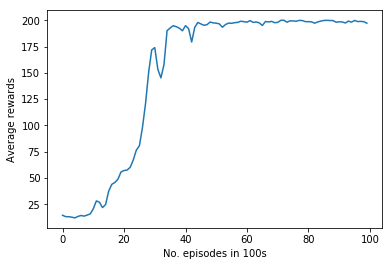

In [190]:
plt.plot(np.arange(len(all_avg_rewards)), all_avg_rewards)
plt.xlabel('No. episodes in 100s')
plt.ylabel('Average rewards')

In [191]:
model.params

array([-0.38008673,  1.62650571,  3.72289387,  7.7428878 ])

[-0.77101531  0.78604245 -0.02394716 -0.4281628 ]


(200, 200.0)

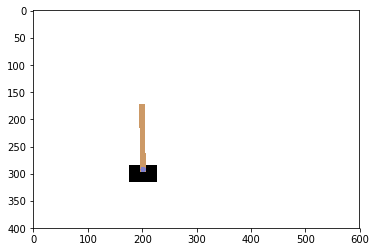

In [194]:
img = None
run_episode(render_=True)